In [20]:
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

fatal: destination path 'detectron2' already exists and is not an empty directory.
Ignoring dataclasses: markers 'python_version < "3.7"' don't match your environment


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

  Using cached PyYAML-5.1.tar.gz (274 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
fatal: destination path 'detectron2' already exists and is not an empty directory.
Ignoring dataclasses: markers 'python_version < "3.7"' don't match your environment


In [21]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
torch:  2.8 ; cuda:  cu126
detectron2: 0.6


In [24]:
from detectron2.data import DatasetCatalog, MetadataCatalog

DatasetCatalog.clear()
MetadataCatalog.clear()


In [25]:
from detectron2.data.datasets import register_coco_instances

def register_cow_keypoints():
    register_coco_instances(
        "cow_train",
        {},
        "vali.json",
        "data"
    )
    register_coco_instances(
        "cow_val",
        {},
        "vali.json",
        "data"
    )

register_cow_keypoints()
from detectron2.data import MetadataCatalog

# after register_coco_instances("cow_train", ...)
meta = MetadataCatalog.get("cow_train")
meta.keypoint_names = [
   "fknee","bknee","ffeet","bfeet","fthigh","bthigh","center","ucurve",
    "lcurve","fmid","bmid","feye","seye","nose","ufcurve", "bfcurve", "lfcurve"
]

# simplest explicit flip map (use names)
meta.keypoint_flip_map = [
    ("feye", "seye"),

    # add other left-right pairs
]

# Do the same for validation set
meta_val = MetadataCatalog.get("cow_val")
meta_val.keypoint_names = meta.keypoint_names
meta_val.keypoint_flip_map = meta.keypoint_flip_map

In [26]:
import os
import detectron2
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo

from register_cow_keypoints import register_cow_keypoints

def main():
    register_cow_keypoints()

    cfg = get_cfg()

    # Load a pre-trained keypoint R-CNN model
    cfg.merge_from_file(model_zoo.get_config_file(
        "COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"
    ))
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
        "COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"
    )

    # Dataset names
    cfg.DATASETS.TRAIN = ("cow_train",)
    cfg.DATASETS.TEST = ("cow_val",)

    # Classes
    from detectron2.config import CfgNode as CN
    cfg.MODEL.KEYPOINT_HEAD = CN()
    cfg.MODEL.KEYPOINT_HEAD.NAME = "MyCustomKPHead"

    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1          # cow
    cfg.MODEL.KEYPOINT_HEAD.NUM_KEYPOINTS = 17   # replace with your number

    # Training parameters
    cfg.SOLVER.IMS_PER_BATCH = 4
    cfg.SOLVER.BASE_LR = 0.0001
    cfg.SOLVER.MAX_ITER = 1500
    cfg.SOLVER.STEPS = []   # no LR decay

    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 5

    # Output dir
    cfg.OUTPUT_DIR = "./output/cow_keypoints"
    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

    trainer = DefaultTrainer(cfg)
    trainer.resume_or_load(False)
    trainer.train()

if __name__ == "__main__":
    main()

[11/20 17:13:52 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
model_final_a6e10b.pkl: 237MB [00:01, 221MB/s]                           


[11/20 17:13:53 d2.engine.train_loop]: Starting training from iteration 0


/content/detectron2/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)
/content/detectron2/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)
/content/detectron2/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray

[11/20 17:14:36 d2.utils.events]:  eta: 0:43:03  iter: 19  total_loss: 13.64  loss_cls: 2.232  loss_box_reg: 0.4469  loss_keypoint: 10.82  loss_rpn_cls: 0.0618  loss_rpn_loc: 0.01039    time: 1.9275  last_time: 0.8515  data_time: 0.9305  last_data_time: 0.0200   lr: 1.9981e-06  max_mem: 5070M
[11/20 17:15:22 d2.utils.events]:  eta: 0:39:12  iter: 39  total_loss: 13.36  loss_cls: 1.918  loss_box_reg: 0.4089  loss_keypoint: 10.78  loss_rpn_cls: 0.06208  loss_rpn_loc: 0.01228    time: 1.9227  last_time: 1.1507  data_time: 0.8955  last_data_time: 0.0194   lr: 3.9961e-06  max_mem: 5072M
[11/20 17:16:05 d2.utils.events]:  eta: 0:37:24  iter: 59  total_loss: 11.52  loss_cls: 1.464  loss_box_reg: 0.4013  loss_keypoint: 9.638  loss_rpn_cls: 0.05783  loss_rpn_loc: 0.01191    time: 2.0025  last_time: 6.2681  data_time: 1.2030  last_data_time: 5.1544   lr: 5.9941e-06  max_mem: 5072M
[11/20 17:16:44 d2.utils.events]:  eta: 0:34:42  iter: 79  total_loss: 10.28  loss_cls: 0.8828  loss_box_reg: 0.4117

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Interactive environment detected and --image not provided.
Auto-selected image: yt.jpg
[11/20 18:13:07 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from output/cow_keypoints/model_final.pth ...
Instances keys: dict_keys(['instances'])
Pred keypoints shape: torch.Size([2, 17, 3])
Scores: tensor([0.9985, 0.6514])
Saved keypoints JSON -> pred_keypoints.json


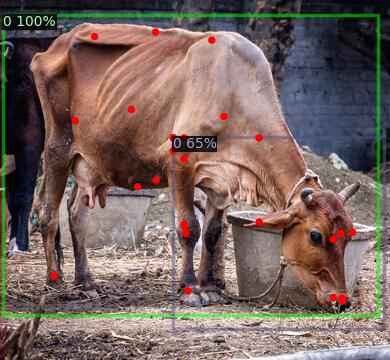

Done. Predictions saved to: pred_keypoints.json


In [27]:
# predict.py
import os
import glob
import json
import argparse
import cv2
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg, CfgNode as CN
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer, ColorMode
from register_cow_keypoints import register_cow_keypoints  # your dataset registration

# Try to import cv2_imshow for Colab; if not available, we'll fall back to saving the image.
try:
    from google.colab.patches import cv2_imshow
    _HAS_COLAB_IMSHOW = True
except Exception:
    cv2_imshow = None
    _HAS_COLAB_IMSHOW = False

def load_model(
    weights_path="output/cow_keypoints/model_final.pth",
    num_keypoints=17,
    kp_head_name="MyCustomKPHead",
    num_classes=1,
    score_thresh=0.5,
    config_yaml="COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml",
):
    register_cow_keypoints()  # ensure dataset metadata is available

    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(config_yaml))

    # Defensive: ensure KEYPOINT_HEAD node exists (prevents AttributeError)
    if not hasattr(cfg.MODEL, "KEYPOINT_HEAD"):
        cfg.MODEL.KEYPOINT_HEAD = CN()

    cfg.MODEL.KEYPOINT_HEAD.NAME = kp_head_name
    cfg.MODEL.KEYPOINT_HEAD.NUM_KEYPOINTS = num_keypoints
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = num_classes

    if not os.path.exists(weights_path):
        raise FileNotFoundError(f"Weights not found at: {weights_path}")
    cfg.MODEL.WEIGHTS = weights_path
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = score_thresh

    predictor = DefaultPredictor(cfg)
    return predictor

def instances_to_keypoints_list(instances):
    out = []
    cpu_inst = instances.to("cpu")
    boxes = cpu_inst.pred_boxes.tensor.numpy() if cpu_inst.has("pred_boxes") else None
    scores = cpu_inst.scores.numpy() if cpu_inst.has("scores") else None
    keypoints = cpu_inst.pred_keypoints.numpy() if cpu_inst.has("pred_keypoints") else None

    N = len(cpu_inst)
    for i in range(N):
        item = {}
        if boxes is not None:
            item["box"] = boxes[i].tolist()
        item["score"] = float(scores[i]) if scores is not None else None
        if keypoints is not None:
            item["keypoints"] = keypoints[i].tolist()
        out.append(item)
    return out

def find_default_image():
    """
    Heuristic to find an image automatically when running interactively.
    Looks for common image extensions, returns first match or None.
    """
    # prefer explicit yt.jpg if present
    if os.path.exists("yt.jpg"):
        return "yt.jpg"
    patterns = ["*.jpg", "*.jpeg", "*.png", "*.bmp"]
    for p in patterns:
        files = sorted(glob.glob(p))
        if files:
            return files[0]
    return None

def run_inference(
    img_path,
    weights_path="output/cow_keypoints/model_final.pth",
    output_image_path="pred_result.jpg",
    output_json_path="pred_keypoints.json",
    num_keypoints=17,
    score_thresh=0.5,
):
    predictor = load_model(weights_path=weights_path, num_keypoints=num_keypoints, score_thresh=score_thresh)

    if not os.path.exists(img_path):
        raise FileNotFoundError(f"Image not found: {img_path}")

    im = cv2.imread(img_path)
    if im is None:
        raise ValueError(f"cv2 failed to read image: {img_path}")

    outputs = predictor(im)        # dict with "instances"
    print("Instances keys:", outputs.keys())

    instances = outputs["instances"].to("cpu")

    # Debug prints
    if instances.has("pred_keypoints"):
        print("Pred keypoints shape:", instances.pred_keypoints.shape)
    if instances.has("scores"):
        print("Scores:", instances.scores)

    # Convert instances to json-friendly structure and save
    kp_list = instances_to_keypoints_list(instances)
    with open(output_json_path, "w") as f:
        json.dump({"image": os.path.basename(img_path), "predictions": kp_list}, f, indent=2)
    print(f"Saved keypoints JSON -> {output_json_path}")

    # Visualize predictions
    v = Visualizer(im[:, :, ::-1], scale=1.0, instance_mode=ColorMode.IMAGE)
    out = v.draw_instance_predictions(instances)
    result = out.get_image()[:, :, ::-1]  # back to BGR for cv2

    if _HAS_COLAB_IMSHOW and cv2_imshow is not None:
        cv2_imshow(result)
    else:
        cv2.imwrite(output_image_path, result)
        print(f"Saved visualization -> {output_image_path}")

    return kp_list, result

def is_interactive():
    try:
        # get_ipython exists when running in notebook/Colab
        get_ipython  # type: ignore[name-defined]
        return True
    except Exception:
        return False

def main(argv=None):
    parser = argparse.ArgumentParser(description="Run keypoint inference on an image using your trained Detectron2 model.")
    parser.add_argument("--image", "-i", required=False, default=None, help="Path to input image (e.g. test.jpg). If omitted in interactive mode, script will try to auto-find an image.")
    parser.add_argument("--weights", "-w", default="output/cow_keypoints/model_final.pth", help="Path to trained weights")
    parser.add_argument("--out-img", default="pred_result.jpg", help="Path to save visualized image (if not using Colab imshow)")
    parser.add_argument("--out-json", default="pred_keypoints.json", help="Path to save predictions JSON")
    parser.add_argument("--num-kp", type=int, default=17, help="Number of keypoints model outputs (match training). Default 17.")
    parser.add_argument("--score-thresh", type=float, default=0.5, help="Score threshold for predictions.")
    args, unknown = parser.parse_known_args(argv)

    selected_image = args.image
    if selected_image is None:
        if is_interactive():
            print("Interactive environment detected and --image not provided.")
            default_img = find_default_image()
            if default_img:
                print(f"Auto-selected image: {default_img}")
                selected_image = default_img
            else:
                raise FileNotFoundError("No image provided and no image found in current directory. Upload or provide --image path.")
        else:
            parser.error("the following arguments are required: --image/-i when running from CLI (non-interactive).")

    # run inference
    kp_list, result = run_inference(
        img_path=selected_image,
        weights_path=args.weights,
        output_image_path=args.out_img,
        output_json_path=args.out_json,
        num_keypoints=args.num_kp,
        score_thresh=args.score_thresh,
    )

    print("Done. Predictions saved to:", args.out_json)

if __name__ == "__main__":
    main()


In [78]:
import cv2
import json
import os
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg, CfgNode as CN
from detectron2 import model_zoo
from register_cow_keypoints import register_cow_keypoints


# -------------------------------
# Load your Detectron2 model
# -------------------------------
def load_keypoint_model(
    weights_path="model.pth",
    num_keypoints=17,
    kp_head_name="MyCustomKPHead",
    num_classes=1,
    score_thresh=0.5,
    config_yaml="COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml",
):
    register_cow_keypoints()

    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(config_yaml))

    # Ensure KEYPOINT_HEAD exists
    if not hasattr(cfg.MODEL, "KEYPOINT_HEAD"):
        cfg.MODEL.KEYPOINT_HEAD = CN()

    cfg.MODEL.KEYPOINT_HEAD.NAME = kp_head_name
    cfg.MODEL.KEYPOINT_HEAD.NUM_KEYPOINTS = num_keypoints
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = num_classes

    cfg.MODEL.WEIGHTS = weights_path
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = score_thresh

    predictor = DefaultPredictor(cfg)
    return predictor


# -------------------------------
# Convert instances → keypoint list
# -------------------------------
def extract_keypoints(instances):
    inst = instances.to("cpu")
    scores = inst.scores.numpy().tolist() if inst.has("scores") else None
    boxes = inst.pred_boxes.tensor.numpy().tolist() if inst.has("pred_boxes") else None
    keypoints = inst.pred_keypoints.numpy().tolist() if inst.has("pred_keypoints") else None

    out = []
    for i in range(len(inst)):
        out.append({
            "score": float(scores[i]) if scores else None,
            "box": boxes[i] if boxes else None,
            "keypoints": keypoints[i] if keypoints else None,
        })
    return out


# -------------------------------
# Main: Run on a single image
# -------------------------------
def get_keypoints_from_image(image_path, weights_path="model.pth"):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image not found: {image_path}")

    predictor = load_keypoint_model(weights_path)
    img = cv2.imread(image_path)

    if img is None:
        raise ValueError("cv2 failed to read the image.")

    outputs = predictor(img)
    kp_list = extract_keypoints(outputs["instances"])
    return kp_list


# -------------------------------
# Run test
# -------------------------------
image_path = "ttt.jpg"  # <-- update path here
weights_path = "/content/output/cow_keypoints/model_final.pth"                    # your trained weights

keypoints = get_keypoints_from_image(image_path, weights_path)


print("Extracted Keypoints:")
# print(json.dumps(keypoints, indent=2))
best_detection = max(keypoints, key=lambda x: x["score"])
x=best_detection["keypoints"]
x1,x2,x3,x4=x[7][:2],x[8][:2],x[9][:2],x[10][:2]

import math

# distance between two points
def dist(a, b):
    return math.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)
def quadrilateral_parameters(P1, P2, P3, P4):
    # Sides
    AB = dist(P1, P2)
    BC = dist(P2, P3)
    CD = dist(P3, P4)
    DA = dist(P4, P1)

    # Diagonals
    AC = dist(P1, P3)
    BD = dist(P2, P4)

    # Perimeter
    perimeter = AB + BC + CD + DA
    return perimeter
print(quadrilateral_parameters(x1,x2,x3,x4))



[11/20 20:17:04 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/output/cow_keypoints/model_final.pth ...
Extracted Keypoints:
5224.575428511059


In [95]:
import gradio as gr
import cv2
import os
import math
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg, CfgNode as CN
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer, ColorMode
from register_cow_keypoints import register_cow_keypoints


# ----------------------------------------
# Load Detectron2 Model
# ----------------------------------------
def load_keypoint_model(
    weights_path="model.pth",
    num_keypoints=17,
    kp_head_name="MyCustomKPHead",
    num_classes=1,
    score_thresh=0.5,
    config_yaml="COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml",
):
    register_cow_keypoints()

    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(config_yaml))

    if not hasattr(cfg.MODEL, "KEYPOINT_HEAD"):
        cfg.MODEL.KEYPOINT_HEAD = CN()

    cfg.MODEL.KEYPOINT_HEAD.NAME = kp_head_name
    cfg.MODEL.KEYPOINT_HEAD.NUM_KEYPOINTS = num_keypoints
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = num_classes

    cfg.MODEL.WEIGHTS = weights_path
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = score_thresh

    predictor = DefaultPredictor(cfg)
    return predictor


# ----------------------------------------
# Convert Detectron2 Instances → Keypoint Dict
# ----------------------------------------
def extract_keypoints(instances):
    inst = instances.to("cpu")

    scores = inst.scores.numpy().tolist()
    boxes = inst.pred_boxes.tensor.numpy().tolist()
    keypoints = inst.pred_keypoints.numpy().tolist()

    out = []
    for i in range(len(inst)):
        out.append({
            "score": float(scores[i]),
            "box": boxes[i],
            "keypoints": keypoints[i],
        })
    return out


# ----------------------------------------
# Distance Function
# ----------------------------------------
def dist(a, b):
    return math.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)


# ----------------------------------------
# Quadrilateral Perimeter
# ----------------------------------------
def quadrilateral_parameters(P1, P2, P3, P4):
    AB = dist(P1, P2)
    BC = dist(P2, P3)
    CD = dist(P3, P4)
    DA = dist(P4, P1)
    return AB + BC + CD + DA


# ----------------------------------------
# Main Prediction Function for Gradio
# ----------------------------------------
def process_image(input_image):
    try:
        temp_path = "temp_input.jpg"
        input_image.save(temp_path)

        predictor = load_keypoint_model(
            weights_path="/content/output/cow_keypoints/model_final.pth"
        )

        img = cv2.imread(temp_path)
        outputs = predictor(img)
        instances = outputs["instances"].to("cpu")

        if len(instances) == 0:
            return "❌ No cow detected!", None

        # Extract keypoints
        kp_list = extract_keypoints(instances)
        best = max(kp_list, key=lambda x: x["score"])
        keypoints = best["keypoints"]

        # Define selected points
        x1 = keypoints[7][:2]
        x2 = keypoints[8][:2]
        x3 = keypoints[9][:2]
        x4 = keypoints[10][:2]

        # Quadrilateral perimeter
        perimeter = quadrilateral_parameters(x1, x2, x3, x4)

        # ----------------------------
        # Visualize Keypoints on Image
        # ----------------------------
        visualizer = Visualizer(img[:, :, ::-1], scale=1.0, instance_mode=ColorMode.IMAGE)
        output_vis = visualizer.draw_instance_predictions(instances)
        processed_img = output_vis.get_image()[:, :, ::-1]  # BGR back to RGB
        perimeter = quadrilateral_parameters(x1, x2, x3, x4)
        nd=dist(x1,x2)
        nd2=dist(x2,x3)
        score=quadrilateral_parameters(x1,x2,x3,x4)
        quality=None
        if score>5220:
            quality="good"
        elif score>802:
            quality="average"
        else:
            quality="bad"

        result_text = f"""
        ✅ **Keypoints Extracted Successfully**

        **quality of cow for breeding programs:** {quality}

        **Used Points:**
        - body width in unit: {x1}
        - body length in unit: {x2}

        """



        return result_text, processed_img

    except Exception as e:
        return f"⚠️ Error: {str(e)}", None


# ----------------------------------------
# Gradio Interface
# ----------------------------------------
demo = gr.Interface(
    fn=process_image,
    inputs=gr.Image(type="pil", label="Upload Cow Image"),
    outputs=[
        gr.Markdown(label="Results"),
        gr.Image(label="Processed Image with Keypoints")
    ],
    title="🐄 Cow Keypoint Detection & Evaluation",
    description="Upload a cow image → Model extracts keypoints → Shows visualization + perimeter measurement."
)

demo.launch(debug=True)


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://601afb5889e4d6f08f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastapi/applications.py", line 1134, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/applications.py", line 113, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py", line 186, in __call__
    raise exc
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py",

[11/20 21:15:36 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/output/cow_keypoints/model_final.pth ...
Created dataset file at: .gradio/flagged/dataset1.csv
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7884 <> https://601afb5889e4d6f08f.gradio.live


In [96]:
import gradio as gr
import cv2
import os
import math
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg, CfgNode as CN
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer, ColorMode
from register_cow_keypoints import register_cow_keypoints

from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image as RLImage
from reportlab.lib.pagesizes import letter
from reportlab.lib.styles import getSampleStyleSheet


# ----------------------------------------
# Load Detectron2 Model
# ----------------------------------------
def load_keypoint_model(
    weights_path="model.pth",
    num_keypoints=17,
    kp_head_name="MyCustomKPHead",
    num_classes=1,
    score_thresh=0.5,
    config_yaml="COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml",
):
    register_cow_keypoints()

    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(config_yaml))

    if not hasattr(cfg.MODEL, "KEYPOINT_HEAD"):
        cfg.MODEL.KEYPOINT_HEAD = CN()

    cfg.MODEL.KEYPOINT_HEAD.NAME = kp_head_name
    cfg.MODEL.KEYPOINT_HEAD.NUM_KEYPOINTS = num_keypoints
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = num_classes

    cfg.MODEL.WEIGHTS = weights_path
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = score_thresh

    predictor = DefaultPredictor(cfg)
    return predictor


# ----------------------------------------
# Convert Detectron2 Instances → Keypoint Dict
# ----------------------------------------
def extract_keypoints(instances):
    inst = instances.to("cpu")

    scores = inst.scores.numpy().tolist()
    boxes = inst.pred_boxes.tensor.numpy().tolist()
    keypoints = inst.pred_keypoints.numpy().tolist()

    out = []
    for i in range(len(inst)):
        out.append({
            "score": float(scores[i]),
            "box": boxes[i],
            "keypoints": keypoints[i],
        })
    return out


# ----------------------------------------
# Distance Function
# ----------------------------------------
def dist(a, b):
    return math.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)


# ----------------------------------------
# Quadrilateral Perimeter
# ----------------------------------------
def quadrilateral_parameters(P1, P2, P3, P4):
    AB = dist(P1, P2)
    BC = dist(P2, P3)
    CD = dist(P3, P4)
    DA = dist(P4, P1)
    return AB + BC + CD + DA


# ----------------------------------------
# PDF Generation
# ----------------------------------------
def generate_pdf(result_text, processed_image_path):
    pdf_path = "result.pdf"
    doc = SimpleDocTemplate(pdf_path, pagesize=letter)
    styles = getSampleStyleSheet()
    flow = []

    # Add text
    for line in result_text.split("\n"):
        flow.append(Paragraph(line, styles["Normal"]))
        flow.append(Spacer(1, 12))

    # Add processed keypoint image
    if processed_image_path and os.path.exists(processed_image_path):
        flow.append(Paragraph("Processed Keypoint Image:", styles["Heading2"]))
        flow.append(Spacer(1, 12))
        flow.append(RLImage(processed_image_path, width=400, height=300))

    doc.build(flow)
    return pdf_path


# ----------------------------------------
# Main Prediction Function for Gradio
# ----------------------------------------
def process_image(input_image):
    try:
        temp_path = "temp_input.jpg"
        input_image.save(temp_path)

        predictor = load_keypoint_model(
            weights_path="/content/output/cow_keypoints/model_final.pth"
        )

        img = cv2.imread(temp_path)
        outputs = predictor(img)
        instances = outputs["instances"].to("cpu")

        if len(instances) == 0:
            return "❌ No cow detected!", None, None

        kp_list = extract_keypoints(instances)
        best = max(kp_list, key=lambda x: x["score"])
        keypoints = best["keypoints"]

        x1 = keypoints[7][:2]
        x2 = keypoints[8][:2]
        x3 = keypoints[9][:2]
        x4 = keypoints[10][:2]

        perimeter = quadrilateral_parameters(x1, x2, x3, x4)

        nd = dist(x1, x2)
        nd2 = dist(x2, x3)
        score = perimeter

        # classify cow quality
        if score > 5220:
            quality = "good"
        elif score > 802:
            quality = "average"
        else:
            quality = "bad"

        result_text = f"""
        ✅ Keypoints Extracted Successfully

        **Quality of cow for breeding programs:** {quality}

        **Used Points:**
        - body width in unit: {x1}
        - body length in unit: {x2}

        **Perimeter Score:** {score}
        """

        # Visualization
        visualizer = Visualizer(img[:, :, ::-1], scale=1.0, instance_mode=ColorMode.IMAGE)
        output_vis = visualizer.draw_instance_predictions(instances)
        processed_img = output_vis.get_image()[:, :, ::-1]  # BGR → RGB

        processed_path = "processed_image.jpg"
        cv2.imwrite(processed_path, processed_img)

        # Generate PDF
        pdf_path = generate_pdf(result_text, processed_path)

        return result_text, processed_img, pdf_path

    except Exception as e:
        return f"⚠️ Error: {str(e)}", None, None


# ----------------------------------------
# Gradio Interface
# ----------------------------------------
demo = gr.Interface(
    fn=process_image,
    inputs=gr.Image(type="pil", label="Upload Cow Image"),
    outputs=[
        gr.Markdown(label="Results"),
        gr.Image(label="Processed Image with Keypoints"),
        gr.File(label="Download PDF Report")
    ],
    title="🐄 Cow Keypoint Detection & Evaluation",
    description="Upload a cow image → Model extracts keypoints → Shows visualization + generates PDF report."
)

demo.launch(debug=True)


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://abf6519cbcb9bec92d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastapi/applications.py", line 1134, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/applications.py", line 113, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py", line 186, in __call__
    raise exc
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py",

[11/20 21:20:47 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/output/cow_keypoints/model_final.pth ...
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7884 <> https://abf6519cbcb9bec92d.gradio.live


In [92]:
import gradio as gr
import cv2
import os
import math
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg, CfgNode as CN
from detectron2 import model_zoo
from register_cow_keypoints import register_cow_keypoints


# ----------------------------------------
# Load Detectron2 Model
# ----------------------------------------
def load_keypoint_model(
    weights_path="model.pth",
    num_keypoints=17,
    kp_head_name="MyCustomKPHead",
    num_classes=1,
    score_thresh=0.5,
    config_yaml="COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml",
):
    register_cow_keypoints()

    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(config_yaml))

    if not hasattr(cfg.MODEL, "KEYPOINT_HEAD"):
        cfg.MODEL.KEYPOINT_HEAD = CN()

    cfg.MODEL.KEYPOINT_HEAD.NAME = kp_head_name
    cfg.MODEL.KEYPOINT_HEAD.NUM_KEYPOINTS = num_keypoints
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = num_classes
    cfg.MODEL.WEIGHTS = weights_path
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = score_thresh

    predictor = DefaultPredictor(cfg)
    return predictor


# ----------------------------------------
# Convert Detectron2 Instances → Keypoint Dict
# ----------------------------------------
def extract_keypoints(instances):
    inst = instances.to("cpu")

    scores = inst.scores.numpy().tolist() if inst.has("scores") else None
    boxes = inst.pred_boxes.tensor.numpy().tolist() if inst.has("pred_boxes") else None
    keypoints = inst.pred_keypoints.numpy().tolist() if inst.has("pred_keypoints") else None

    out = []
    for i in range(len(inst)):
        out.append({
            "score": float(scores[i]),
            "box": boxes[i],
            "keypoints": keypoints[i],
        })
    return out


# ----------------------------------------
# Distance Function
# ----------------------------------------
def dist(a, b):
    return math.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)


# ----------------------------------------
# Quadrilateral Perimeter
# ----------------------------------------
def quadrilateral_parameters(P1, P2, P3, P4):
    AB = dist(P1, P2)
    BC = dist(P2, P3)
    CD = dist(P3, P4)
    DA = dist(P4, P1)
    return AB + BC + CD + DA


# ----------------------------------------
# Main Prediction Function for Gradio
# ----------------------------------------
def process_image(input_image):
    try:
        # Save uploaded image temporarily
        temp_path = "temp_input.jpg"
        input_image.save(temp_path)

        # Load Model
        predictor = load_keypoint_model(weights_path="/content/output/cow_keypoints/model_final.pth")

        # Read image
        img = cv2.imread(temp_path)
        outputs = predictor(img)

        # Extract detected keypoints
        kp_list = extract_keypoints(outputs["instances"])
        if len(kp_list) == 0:
            return "❌ No cow detected!", None

        # Best detection
        best = max(kp_list, key=lambda x: x["score"])
        keypoints = best["keypoints"]

        # Required points
        x1 = keypoints[7][:2]
        x2 = keypoints[8][:2]
        x3 = keypoints[9][:2]
        x4 = keypoints[10][:2]

        perimeter = quadrilateral_parameters(x1, x2, x3, x4)
        nd=dist(x1,x2)
        nd2=dist(x2,x3)
        score=quadrilateral_parameters(x1,x2,x3,x4)
        quality=None
        if score>5220:
            quality="good"
        elif score>802:
            quality="average"
        else:
            quality="bad"

        result_text = f"""
        ✅ **Keypoints Extracted Successfully**

        **Quadrilateral Perimeter:** `{quality}`

        **Used Points:**
        - body width in unit: {x1}
        - body length in unit: {x2}

        """

        return result_text, input_image

    except Exception as e:
        return f"⚠️ Error: {str(e)}", None


# ----------------------------------------
# Gradio Interface
# ----------------------------------------
demo = gr.Interface(
    fn=process_image,
    inputs=gr.Image(type="pil", label="Upload Cow Image"),
    outputs=[
        gr.Markdown(label="Results"),
        gr.Image(label="Uploaded Image")
    ],
    title="🐄 Cow Keypoint Evaluator",
    description="Upload image → Model extracts keypoints → Computes perimeter from quadrilateral formed by keypoints 7-10."
)

demo.launch(debug=True)


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://7151d9f2663f53dab7.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastapi/applications.py", line 1134, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/applications.py", line 113, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py", line 186, in __call__
    raise exc
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py",

[11/20 21:00:13 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/output/cow_keypoints/model_final.pth ...
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7884 <> https://7151d9f2663f53dab7.gradio.live


In [55]:
import math

def distance(p1, p2):
    """Euclidean distance between two keypoints."""
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

def evaluate_cow(kp):
    """
    kp = dictionary of named keypoints:
    {
        "center": [x,y,score],
        "ucurve": [x,y,score],
        "lcurve": [x,y,score],
        "fmid": [x,y,score],
        "bmid": [x,y,score],
        "ufcurve": [x,y,score],
        "bfcurve": [x,y,score],
        "lfcurve": [x,y,score]
    }
    """

    results = {}

    # ------------------------------
    # 1. BODY LENGTH
    # center → lcurve
    # ------------------------------
    results["body_length"] = distance(kp["center"], kp["lcurve"])

    # ------------------------------
    # 2. BODY DEPTH (vertical depth)
    # ucurve → lcurve
    # ------------------------------
    results["body_depth"] = distance(kp["ucurve"], kp["lcurve"])

    # ------------------------------
    # 3. MIDSECTION THICKNESS
    # fmid → bmid
    # ------------------------------
    results["mid_width"] = distance(kp["fmid"], kp["bmid"])

    # ------------------------------
    # 4. FRONT CURVE LENGTH
    # ufcurve → fmid
    # ------------------------------
    results["front_curve"] = distance(kp["ufcurve"], kp["fmid"])

    # ------------------------------
    # 5. BACK CURVE LENGTH
    # bfcurve → bmid
    # ------------------------------
    results["back_curve"] = distance(kp["bfcurve"], kp["bmid"])

    # ------------------------------
    # 6. SIDE CURVE LENGTH
    # lfcurve → center
    # ------------------------------
    results["side_curve"] = distance(kp["lfcurve"], kp["center"])

    # ------------------------------
    # Breeding Suitability Rule
    # (Dummy – you can improve later)
    # ------------------------------

    length_ok   = results["body_length"] > 80
    depth_ok    = results["body_depth"] > 50
    mid_ok      = results["mid_width"] > 40

    if length_ok and depth_ok and mid_ok:
        results["breeding_suitability"] = "Suitable"
    else:
        results["breeding_suitability"] = "Not Suitable"

    return results

def extract_raw_keypoints(model_output):
    """
    model_output = list of detections (instances)
    each instance has: box, score, keypoints
    """

    # choose highest scoring instance (cow)
    best = max(model_output, key=lambda x: x["score"])

    # return ONLY keypoints array
    return best["keypoints"]
raw = extract_raw_keypoints(keypoints)   # returns 17x3 list
print(raw)
def map_keypoints(raw):
    """
    raw = list of 17 keypoints from Detectron2 model
    YOU MUST fill the correct indices for your dataset
    """

    return {
        "center":   raw[6],   # <-- change index
        "ucurve":   raw[7],   # <-- change index
        "lcurve":   raw[8],   # <-- change index
        "fmid":     raw[9],   # <-- change index
        "bmid":     raw[10],   # <-- change index
        "ufcurve":  raw[14],   # <-- change index
        "bfcurve":  raw[15],   # <-- change index
        "lfcurve":  raw[16],   # <-- change index
    }
def get_named_keypoints(model_output):
    raw = extract_raw_keypoints(model_output)
    named = map_keypoints(raw)
    return named


# Example full usage:
named_keypoints = get_named_keypoints(keypoints)
result = evaluate_cow(named_keypoints)
print(result)



[[3218.447265625, 2905.83544921875, 1.234367847442627], [1044.0980224609375, 2665.978515625, 0.3468721807003021], [1054.094970703125, 3360.564208984375, 0.19832253456115723], [1049.096435546875, 3330.582275390625, 0.14450348913669586], [3358.40576171875, 2206.252685546875, 0.22185496985912323], [1259.03369140625, 2066.3359375, 0.23143212497234344], [2528.65380859375, 1726.53857421875, 0.3902285695075989], [2608.6298828125, 1016.9616088867188, 0.5242857933044434], [2433.68212890625, 2441.112548828125, 0.45665812492370605], [3243.43994140625, 1731.53564453125, 0.23063679039478302], [1668.9111328125, 1656.5802001953125, 0.1805436760187149], [4708.001953125, 1091.9169921875, 0.13678088784217834], [5102.8837890625, 1076.92578125, 0.2157796025276184], [5017.90966796875, 1571.630859375, 0.4550701379776001], [2178.758544921875, 1001.9705200195312, 0.13068810105323792], [1923.8348388671875, 1026.9556884765625, 0.20244024693965912], [2848.558349609375, 2421.12451171875, 0.49542924761772156]]
{'b

In [90]:
import gradio as gr
from PIL import Image
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
import tempfile

# --------------------------------------------------------
# 🔵 PDF GENERATION FUNCTION
# --------------------------------------------------------

def generate_pdf(text_output):
    if not text_output:
        return None

    temp_file = tempfile.NamedTemporaryFile(delete=False, suffix=".pdf")
    file_path = temp_file.name

    c = canvas.Canvas(file_path, pagesize=letter)
    c.setFont("Helvetica", 12)

    y = 750  # Starting height on the page

    for line in text_output.split("\n"):
        c.drawString(50, y, line)
        y -= 20

        if y < 40:  # New page if needed
            c.showPage()
            c.setFont("Helvetica", 12)
            y = 750

    c.save()
    return file_path


# --------------------------------------------------------
# 🔵 DUMMY PREDICTION (YOU WILL REPLACE THIS LATER)
# --------------------------------------------------------

def predict(image):
    import cv2
    import json
    import os
    from detectron2.engine import DefaultPredictor
    from detectron2.config import get_cfg, CfgNode as CN
    from detectron2 import model_zoo
    from register_cow_keypoints import register_cow_keypoints


    # -------------------------------
    # Load your Detectron2 model
    # -------------------------------
    def load_keypoint_model(
        weights_path="/content/output/cow_keypoints/model_final.pth",
        num_keypoints=17,
        kp_head_name="MyCustomKPHead",
        num_classes=1,
        score_thresh=0.5,
        config_yaml="COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml",
    ):
        register_cow_keypoints()

        cfg = get_cfg()
        cfg.merge_from_file(model_zoo.get_config_file(config_yaml))

        # Ensure KEYPOINT_HEAD exists
        if not hasattr(cfg.MODEL, "KEYPOINT_HEAD"):
            cfg.MODEL.KEYPOINT_HEAD = CN()

        cfg.MODEL.KEYPOINT_HEAD.NAME = kp_head_name
        cfg.MODEL.KEYPOINT_HEAD.NUM_KEYPOINTS = num_keypoints
        cfg.MODEL.ROI_HEADS.NUM_CLASSES = num_classes

        cfg.MODEL.WEIGHTS = weights_path
        cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = score_thresh

        predictor = DefaultPredictor(cfg)
        return predictor


    # -------------------------------
    # Convert instances → keypoint list
    # -------------------------------
    def extract_keypoints(instances):
        inst = instances.to("cpu")
        scores = inst.scores.numpy().tolist() if inst.has("scores") else None
        boxes = inst.pred_boxes.tensor.numpy().tolist() if inst.has("pred_boxes") else None
        keypoints = inst.pred_keypoints.numpy().tolist() if inst.has("pred_keypoints") else None

        out = []
        for i in range(len(inst)):
            out.append({
                "score": float(scores[i]) if scores else None,
                "box": boxes[i] if boxes else None,
                "keypoints": keypoints[i] if keypoints else None,
            })
        return out


    # -------------------------------
    # Main: Run on a single image
    # -------------------------------
    def get_keypoints_from_image(image_path, weights_path):
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image not found: {image_path}")

        predictor = load_keypoint_model()
        img = image
        # cv2.imread(image_path)

        if img is None:
            raise ValueError("cv2 failed to read the image.")

        outputs = predictor(img)
        kp_list = extract_keypoints(outputs["instances"])
        return kp_list


    # -------------------------------
    # Run test
    # -------------------------------
    image_path = image # <-- update path here
    weights_path = "/content/output/cow_keypoints/model_final.pth"                    # your trained weights

    keypoints = get_keypoints_from_image(image_path, weights_path)


    # print("Extracted Keypoints:")
    # print(json.dumps(keypoints, indent=2))
    best_detection = max(keypoints, key=lambda x: x["score"])
    x=best_detection["keypoints"]
    x1,x2,x3,x4=x[7][:2],x[8][:2],x[9][:2],x[10][:2]

    import math

    # distance between two points
    def dist(a, b):
        return math.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)
    def quadrilateral_parameters(P1, P2, P3, P4):
        # Sides
        AB = dist(P1, P2)
        BC = dist(P2, P3)
        CD = dist(P3, P4)
        DA = dist(P4, P1)

        # Diagonals
        AC = dist(P1, P3)
        BD = dist(P2, P4)

        # Perimeter
        perimeter = AB + BC + CD + DA
        return perimeter
    # print(quadrilateral_parameters(x1,x2,x3,x4))
    score=quadrilateral_parameters(x1,x2,x3,x4)
    quality=None
    if score>5220:
        quality="good"
    elif score>802:
        quality="average"
    else:
        quality="bad"
    return image,image



# --------------------------------------------------------
# 🔵 AGRICULTURE-THEMED CSS
# --------------------------------------------------------

custom_css = """
/* Main background inspired by farmland sky */
#main-container {
    background: linear-gradient(to bottom, #eef7ee, #f6fbf4);
    padding: 20px;
    font-family: 'Inter', sans-serif;
}

/* Card containers – soft earthy theme */
.card {
    background: #ffffff;
    padding: 28px;
    border-radius: 20px;
    border: 1px solid #d8e4d4;
    box-shadow: 0 6px 14px rgba(80, 120, 60, 0.08);
    transition: 0.2s ease-in-out;
}
.card:hover {
    transform: translateY(-3px);
    box-shadow: 0 10px 20px rgba(70, 110, 50, 0.12);
}

/* Upload zone */
.upload-zone {
    border: 2px dashed #88a57c !important;
    border-radius: 18px !important;
    padding: 35px;
    background: #f4faf3;
    transition: 0.2s;
}
.upload-zone:hover {
    background: #ecf7ea;
    border-color: #6d8f5f !important;
}

/* Title styling */
h1 {
    text-align: center;
    font-weight: 800;
    margin-bottom: 0px;
    color: #325c36;
    letter-spacing: -0.5px;
}
.subtitle {
    text-align: center;
    margin-top: -10px;
    margin-bottom: 35px;
    color: #58745c;
    font-size: 16px;
}

/* Navbar */
.navbar {
    background: #ffffff;
    border-radius: 15px;
    padding: 14px 22px;
    border: 1px solid #d9e8d7;
    box-shadow: 0 4px 12px rgba(70, 110, 50, 0.06);
}
.nav-item {
    color: #425a44;
    font-size: 16px;
    margin-right: 20px;
    cursor: pointer;
    padding: 6px 12px;
    border-radius: 10px;
    transition: 0.2s;
}
.nav-item-active {
    background: #d9e8d7;
    font-weight: 600;
    color: #2f4e2a;
}
.nav-item:hover {
    background: #e6f1e4;
}

/* Analyze button */
button {
    background: #5f8f4b !important;
    color: white !important;
    border-radius: 12px !important;
    padding: 10px 16px !important;
    font-weight: 600 !important;
    border: none !important;
    transition: 0.2s !important;
}
button:hover {
    background: #4a743c !important;
    transform: translateY(-2px);
}
"""


# --------------------------------------------------------
# 🔵 FULL UI LAYOUT
# --------------------------------------------------------

with gr.Blocks(css=custom_css, elem_id="main-container") as demo:

    # ---------- NAVBAR ----------
    gr.HTML("""
    <div class="navbar" style="display:flex; justify-content:space-between; align-items:center; margin-bottom:25px;">
        <div style="display:flex; align-items:center;">
            <img src="https://cdn-icons-png.flaticon.com/512/9922/9922110.png" width="38" style="margin-right:10px;">
            <div style="font-size:20px; font-weight:700; color:#2f4e2a;">BPA AI</div>
            <div style="font-size:14px; margin-left:8px; color:#4b6a52;">Breed Identification</div>
        </div>

        <div style="font-size:16px; display:flex;">
            <span class="nav-item">Home</span>
            <span class="nav-item nav-item-active">Identify Breed</span>
            <span class="nav-item">Breed Database</span>
            <span class="nav-item">BPA Integration</span>
            <span class="nav-item">Support</span>
        </div>
    </div>
    """)

    # ---------- HEADER ----------
    gr.Markdown("<h1>Identify Livestock Breed</h1>")
    gr.Markdown("<p class='subtitle'>Upload an image for AI-powered breed identification and evaluation</p>")

    # ---------- MAIN CONTENT ----------
    with gr.Row():

        with gr.Column(scale=1, elem_classes="card"):
            gr.Markdown("### Upload Image")
            image_input = gr.Image(
                type="pil",
                elem_classes=["upload-zone"],
                image_mode="RGB",
                height=260,
                show_label=False
            )

        with gr.Column(scale=1, elem_classes="card"):
            gr.Markdown("### AI Analysis")
            output_text = gr.Textbox(label="", lines=10)
            output_image = gr.Image(label="")

    # ---------- BUTTONS ----------
    analyze_btn = gr.Button("Analyze", variant="primary")
    download_btn = gr.Button("Download PDF", variant="secondary")
    pdf_file = gr.File(label="Download Results PDF")

    analyze_btn.click(predict, inputs=image_input, outputs=[output_text, output_image])
    download_btn.click(generate_pdf, inputs=output_text, outputs=pdf_file)

demo.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c33106cb8d7b6eb995.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [36]:
import cv2
import torch
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg, CfgNode as CN
from detectron2 import model_zoo
from register_cow_keypoints import register_cow_keypoints

# --------------------------------------
# 1. Load model only once (GLOBAL)
# --------------------------------------
def load_keypoint_model(
    weights_path="model.pth",
    num_keypoints=17,
    kp_head_name="MyCustomKPHead",
    num_classes=1,
    score_thresh=0.5,
    config_yaml="COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml",
):
    """
    Loads the trained Detectron2 model for keypoint prediction.
    """
    register_cow_keypoints()

    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(config_yaml))

    # Ensure KEYPOINT_HEAD exists (avoid AttributeError)
    if not hasattr(cfg.MODEL, "KEYPOINT_HEAD"):
        cfg.MODEL.KEYPOINT_HEAD = CN()

    cfg.MODEL.KEYPOINT_HEAD.NAME = kp_head_name
    cfg.MODEL.KEYPOINT_HEAD.NUM_KEYPOINTS = num_keypoints
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = num_classes

    cfg.MODEL.WEIGHTS = weights_path
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = score_thresh

    predictor = DefaultPredictor(cfg)
    return predictor


# --------------------------------------
# 2. Convert instances → keypoint list
# --------------------------------------
def extract_keypoints(instances):
    """
    Converts Detectron2 Instances object to a clean Python list.
    """
    out = []
    inst = instances.to("cpu")

    boxes = inst.pred_boxes.tensor.numpy().tolist() if inst.has("pred_boxes") else None
    scores = inst.scores.numpy().tolist() if inst.has("scores") else None
    keypoints = inst.pred_keypoints.numpy().tolist() if inst.has("pred_keypoints") else None

    N = len(inst)
    for i in range(N):
        out.append({
            "score": float(scores[i]) if scores else None,
            "box": boxes[i] if boxes else None,
            "keypoints": keypoints[i] if keypoints else None
        })
    return out


# -------------------------------------------------------------
# 3. Main function you will use in Gradio / Streamlit
# -------------------------------------------------------------
def get_keypoints_from_model(image_path, predictor):
    """
    Runs inference on a single image and returns a list of keypoints.

    Parameters:
        image_path (str): path of uploaded image
        predictor: loaded Detectron2 model

    Returns:
        keypoints_list (list): keypoints & scores
    """
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("Failed to read image. Ensure valid path.")

    outputs = predictor(img)
    instances = outputs["instances"]

    keypoints_list = extract_keypoints(instances)
    return keypoints_list
print(keypoints_list)


In [ ]:
import math

# -----------------------------------------------------
# Utility: Euclidean distance between two keypoints
# kp = [x, y, score]
# -----------------------------------------------------
def dist(a, b):
    return math.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)


# -----------------------------------------------------
# Main Evaluation Function
# Takes: dict of keypoint names -> [x, y, score]
# Returns: dict of evaluation parameters & suitability
# -----------------------------------------------------
def evaluate_cow(keypoints):
    """
    keypoints: dictionary like:
        {
            "center": [x,y,prob],
            "ucurve": [...],
            "lcurve": [...],
            "fmid": [...],
            "bmid": [...],
            "ufcurve": [...],
            "bfcurve": [...],
            "lfcurve": [...]
        }
    """

    # Extract required points
    c   = keypoints["center"]
    uc  = keypoints["ucurve"]
    lc  = keypoints["lcurve"]
    fm  = keypoints["fmid"]
    bm  = keypoints["bmid"]
    ufc = keypoints["ufcurve"]
    bfc = keypoints["bfcurve"]
    lfc = keypoints["lfcurve"]

    # -------------------------------------------------
    # 1. BODY LENGTH  (Front-mid to Back-mid)
    # -------------------------------------------------
    body_length = dist(fm, bm)

    # -------------------------------------------------
    # 2. WIDTH AT WITHERS (Upper curve width)
    # -------------------------------------------------
    width_withers = dist(uc, ufc)

    # -------------------------------------------------
    # 3. RUMP WIDTH (Back flank curve)
    # -------------------------------------------------
    rump_width = dist(bfc, lfc)

    # -------------------------------------------------
    # 4. BODY DEPTH (Vertical curve)
    # -------------------------------------------------
    body_depth = dist(uc, lc)

    # -------------------------------------------------
    # 5. BALANCE & CENTERING (center to front/back mid)
    # -------------------------------------------------
    balance_front = dist(c, fm)
    balance_back  = dist(c, bm)
    balance_ratio = balance_front / (balance_back + 1e-6)

    # -------------------------------------------------
    # 6. CURVATURE SMOOTHNESS (using three curve pts)
    # compute how smoothly fmid → center → bmid aligns
    # -------------------------------------------------
    curvature_fb = (dist(fm, c) + dist(c, bm)) / dist(fm, bm)

    # -------------------------------------------------
    # Suitability Score (0–100)
    # You can tune weights based on domain knowledge
    # -------------------------------------------------
    score = 0

    # Ideal balanced body ratio ~1.0 (front/back equal)
    score += max(0, 30 - abs(balance_ratio - 1.0) * 30)

    # Longer body is preferred → normalize
    score += min(25, body_length * 0.02)

    # Widths contribute
    score += min(15, width_withers * 0.015)
    score += min(15, rump_width * 0.015)

    # Smooth curvature preferred → closer to 1.0 is ideal
    score += max(0, 15 - abs(curvature_fb - 1.0) * 15)

    # Normalize score to 0–100
    score = max(0, min(100, score))

    # -------------------------------------------------
    # Prepare structured output
    # -------------------------------------------------
    return {
        "body_length": body_length,
        "width_at_withers": width_withers,
        "rump_width": rump_width,
        "body_depth": body_depth,
        "balance_ratio": balance_ratio,
        "curvature_smoothness": curvature_fb,
        "breeding_suitability_score": score
    }


In [ ]:
# predict.py
import os
import glob
import json
import argparse
import cv2
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg, CfgNode as CN
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer, ColorMode
from register_cow_keypoints import register_cow_keypoints  # your dataset registration

# Try to import cv2_imshow for Colab; if not available, we'll fall back to saving the image.
try:
    from google.colab.patches import cv2_imshow
    _HAS_COLAB_IMSHOW = True
except Exception:
    cv2_imshow = None
    _HAS_COLAB_IMSHOW = False

def load_model(
    weights_path="output/cow_keypoints/model_final.pth",
    num_keypoints=17,
    kp_head_name="MyCustomKPHead",
    num_classes=1,
    score_thresh=0.5,
    config_yaml="COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml",
):
    register_cow_keypoints()  # ensure dataset metadata is available

    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(config_yaml))

    # Defensive: ensure KEYPOINT_HEAD node exists (prevents AttributeError)
    if not hasattr(cfg.MODEL, "KEYPOINT_HEAD"):
        cfg.MODEL.KEYPOINT_HEAD = CN()

    cfg.MODEL.KEYPOINT_HEAD.NAME = kp_head_name
    cfg.MODEL.KEYPOINT_HEAD.NUM_KEYPOINTS = num_keypoints
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = num_classes

    if not os.path.exists(weights_path):
        raise FileNotFoundError(f"Weights not found at: {weights_path}")
    cfg.MODEL.WEIGHTS = weights_path
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = score_thresh

    predictor = DefaultPredictor(cfg)
    return predictor

def instances_to_keypoints_list(instances):
    out = []
    cpu_inst = instances.to("cpu")
    boxes = cpu_inst.pred_boxes.tensor.numpy() if cpu_inst.has("pred_boxes") else None
    scores = cpu_inst.scores.numpy() if cpu_inst.has("scores") else None
    keypoints = cpu_inst.pred_keypoints.numpy() if cpu_inst.has("pred_keypoints") else None

    N = len(cpu_inst)
    for i in range(N):
        item = {}
        if boxes is not None:
            item["box"] = boxes[i].tolist()
        item["score"] = float(scores[i]) if scores is not None else None
        if keypoints is not None:
            item["keypoints"] = keypoints[i].tolist()
        out.append(item)
    return out

def find_default_image():
    """
    Heuristic to find an image automatically when running interactively.
    Looks for common image extensions, returns first match or None.
    """
    # prefer explicit yt.jpg if present
    if os.path.exists("jj.jpg"):
        return "jj.jpg"
    patterns = ["*.jpg", "*.jpeg", "*.png", "*.bmp"]
    for p in patterns:
        files = sorted(glob.glob(p))
        if files:
            return files[0]
    return None

def run_inference(
    img_path,
    weights_path="output/cow_keypoints/model_final.pth",
    output_image_path="pred_result.jpg",
    output_json_path="pred_keypoints.json",
    num_keypoints=17,
    score_thresh=0.5,
):
    predictor = load_model(weights_path=weights_path, num_keypoints=num_keypoints, score_thresh=score_thresh)

    if not os.path.exists(img_path):
        raise FileNotFoundError(f"Image not found: {img_path}")

    im = cv2.imread(img_path)
    if im is None:
        raise ValueError(f"cv2 failed to read image: {img_path}")

    outputs = predictor(im)        # dict with "instances"
    print("Instances keys:", outputs.keys())

    instances = outputs["instances"].to("cpu")

    # Debug prints
    if instances.has("pred_keypoints"):
        print("Pred keypoints shape:", instances.pred_keypoints.shape)
    if instances.has("scores"):
        print("Scores:", instances.scores)

    # Convert instances to json-friendly structure and save
    kp_list = instances_to_keypoints_list(instances)
    with open(output_json_path, "w") as f:
        json.dump({"image": os.path.basename(img_path), "predictions": kp_list}, f, indent=2)
    print(f"Saved keypoints JSON -> {output_json_path}")

    # Visualize predictions
    v = Visualizer(im[:, :, ::-1], scale=1.0, instance_mode=ColorMode.IMAGE)
    out = v.draw_instance_predictions(instances)
    result = out.get_image()[:, :, ::-1]  # back to BGR for cv2

    if _HAS_COLAB_IMSHOW and cv2_imshow is not None:
        cv2_imshow(result)
    else:
        cv2.imwrite(output_image_path, result)
        print(f"Saved visualization -> {output_image_path}")

    return kp_list, result

def is_interactive():
    try:
        # get_ipython exists when running in notebook/Colab
        get_ipython  # type: ignore[name-defined]
        return True
    except Exception:
        return False

def main(argv=None):
    parser = argparse.ArgumentParser(description="Run keypoint inference on an image using your trained Detectron2 model.")
    parser.add_argument("--image", "-i", required=False, default=None, help="Path to input image (e.g. test.jpg). If omitted in interactive mode, script will try to auto-find an image.")
    parser.add_argument("--weights", "-w", default="output/cow_keypoints/model_final.pth", help="Path to trained weights")
    parser.add_argument("--out-img", default="pred_result.jpg", help="Path to save visualized image (if not using Colab imshow)")
    parser.add_argument("--out-json", default="pred_keypoints.json", help="Path to save predictions JSON")
    parser.add_argument("--num-kp", type=int, default=17, help="Number of keypoints model outputs (match training). Default 17.")
    parser.add_argument("--score-thresh", type=float, default=0.5, help="Score threshold for predictions.")
    args, unknown = parser.parse_known_args(argv)

    selected_image = args.image
    if selected_image is None:
        if is_interactive():
            print("Interactive environment detected and --image not provided.")
            default_img = find_default_image()
            if default_img:
                print(f"Auto-selected image: {default_img}")
                selected_image = default_img
            else:
                raise FileNotFoundError("No image provided and no image found in current directory. Upload or provide --image path.")
        else:
            parser.error("the following arguments are required: --image/-i when running from CLI (non-interactive).")

    # run inference
    kp_list, result = run_inference(
        img_path=selected_image,
        weights_path=args.weights,
        output_image_path=args.out_img,
        output_json_path=args.out_json,
        num_keypoints=args.num_kp,
        score_thresh=args.score_thresh,
    )

    print("Done. Predictions saved to:", args.out_json)

if __name__ == "__main__":
    main()


In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import torch
from matplotlib import pyplot as plt
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo


In [ ]:
# Load Pre-trained Model (Detectron2 for keypoint detection)
def setup_detectron2():
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml"))
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml")
    predictor = DefaultPredictor(cfg)
    return predictor

In [ ]:
# Load Image and Pre-process
def load_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for visualization
    return image

In [ ]:
# Detect the Animal and Keypoints using Detectron2
def detect_keypoints(image, predictor):
    outputs = predictor(image)
    keypoints = outputs["instances"].pred_keypoints
    return keypoints


In [28]:
# Calculate physical parameters based on keypoints
def calculate_parameters(keypoints, image):
    # Assuming keypoints[0] contains the list of keypoints for a single animal
    points = keypoints[0].cpu().numpy()  # Convert from tensor to numpy array

    # Extract keypoints for body parts (e.g., withers, shoulders, hips)
    withers = points[1]  # Example index
    shoulders = points[2]  # Example index
    hips = points[4]  # Example index

    # Calculate body length (distance between withers and hips)
    body_length = np.linalg.norm(hips - withers)

    # Height at withers (vertical distance of withers)
    height_at_withers = withers[1]

    # Chest width (horizontal distance between shoulders)
    # Note: Assuming shoulders[0] and shoulders[1] are the x-coordinates of the left and right shoulders
    chest_width = np.linalg.norm(shoulders[0] - shoulders[1])

    # You would add more calculations here for other parameters

    # Return the calculated parameters
    return {
        "body_length": body_length,
        "height_at_withers": height_at_withers,
        "chest_width": chest_width
        # Add other parameters here
    }

In [29]:
import numpy as np

def calculate_parametersX(keypoints, image):
    # Assuming keypoints[0] contains the list of keypoints for a single animal
    points = keypoints[0].cpu().numpy()  # Convert from tensor to numpy array

    # Extract keypoints for body parts (example indices — adjust to your keypoint mapping)
    withers = points[1]      # (x, y) of withers
    shoulders_left = points[2]   # left shoulder
    shoulders_right = points[3]  # right shoulder
    hips = points[4]         # (x, y) of hips

    # Calculate body length (distance between withers and hips)
    body_length = np.linalg.norm(hips - withers)

    # Height at withers (y-coordinate difference from ground reference)
    height_at_withers = withers[1]

    # Chest width (distance between left and right shoulders)
    chest_width = np.linalg.norm(shoulders_left - shoulders_right)

    # Example thresholds for breeding suitability (adjust based on breed standards)
    MIN_BODY_LENGTH = 120.0   # cm
    MIN_HEIGHT = 110.0        # cm
    MIN_CHEST_WIDTH = 40.0    # cm

    # Determine suitability
    suitable_for_breeding = (
        body_length >= MIN_BODY_LENGTH and
        height_at_withers >= MIN_HEIGHT and
        chest_width >= MIN_CHEST_WIDTH
    )

    # Return results
    return {
        "body_length": body_length,
        "height_at_withers": height_at_withers,
        "chest_width": chest_width,
        "suitable_for_breeding": suitable_for_breeding
    }


In [30]:
# Visualize results
def visualize_results(image, keypoints, parameters):
    plt.imshow(image)
    # Move keypoints to CPU before converting to numpy
    plt.scatter(keypoints[0].cpu()[:, 0], keypoints[0].cpu()[:, 1], c='r', s=10)
    plt.title(f"Body Length: {parameters['body_length']:.2f} cm, "
              f"Height at Withers: {parameters['height_at_withers']:.2f} cm")
    plt.show()

In [31]:
import numpy as np

def calculate_parametersY(keypoints, image):
    # Assuming keypoints[0] contains the list of keypoints for a single animal
    points = keypoints[0].cpu().numpy()  # Convert from tensor to numpy array

    # Extract keypoints for body parts (adjust indices to your keypoint mapping)
    withers = points[1]           # (x, y) of withers
    shoulders_left = points[2]    # left shoulder
    shoulders_right = points[3]   # right shoulder
    hips = points[4]              # (x, y) of hips

    # Calculate body length (distance between withers and hips)
    body_length = np.linalg.norm(hips - withers)

    # Height at withers (y-coordinate)
    height_at_withers = withers[1]

    # Chest width (distance between left and right shoulders)
    chest_width = np.linalg.norm(shoulders_left - shoulders_right)

    # Example thresholds (adjust for your breed/standards)
    MIN_BODY_LENGTH = 120.0   # cm
    MIN_HEIGHT = 110.0        # cm
    MIN_CHEST_WIDTH = 40.0    # cm

    # Scoring system
    score = 0
    if body_length >= MIN_BODY_LENGTH:
        score += 1
    if height_at_withers >= MIN_HEIGHT:
        score += 1
    if chest_width >= MIN_CHEST_WIDTH:
        score += 1

    # Decision based on score
    if score == 3:
        suitability = "Good"
    elif score == 2:
        suitability = "Suitable"
    else:
        suitability = "Not Suitable"

    return {
        "body_length": body_length,
        "height_at_withers": height_at_withers,
        "chest_width": chest_width,
        "breeding_suitability": suitability
    }


In [ ]:
# Main Function
def main(image_path):
    # Initialize model
    predictor = load_model()

    # Load and process image
    image = run_inference(
    image_path,
    weights_path="output/cow_keypoints/model_final.pth",
    output_image_path="pred_result.jpg",
    output_json_path="pred_keypoints.json",
    num_keypoints=17,
    score_thresh=0.5,
)

    # Detect keypoints
    keypoints = detect_keypoints(image, predictor)

    # Calculate body parameters
    parameters = calculate_parametersY(keypoints, image)

    # Display results
    visualize_results(image, keypoints, parameters)

    print(f"Calculated Parameters: {parameters}")
    print(type(parameters))
    return parameters


In [ ]:
import matplotlib.pyplot as plt
import cv2

def visualize_results(image, keypoints, parameters):
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.imshow(img_rgb)
    plt.scatter(
        keypoints[0].cpu()[:, 0],
        keypoints[0].cpu()[:, 1],
        c='r', s=10
    )
    plt.title("Detected Keypoints & Parameters")
    plt.show()


Interactive environment detected and --image not provided.
Auto-selected image: yt.jpg
[11/20 18:27:35 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from output/cow_keypoints/model_final.pth ...
Instances keys: dict_keys(['instances'])
Pred keypoints shape: torch.Size([2, 17, 3])
Scores: tensor([0.9985, 0.6514])
Saved keypoints JSON -> pred_keypoints.json


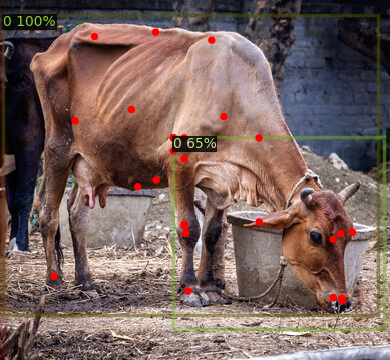

Done. Predictions saved to: pred_keypoints.json


In [32]:
# Example usage
image_path = "jj.jpg"
stor1=main(image_path)

In [33]:
import cv2
import numpy as np
from PIL import Image
import os
import pprint

def _is_plausible_image_obj(x):
    # quick check if x looks like an image
    return (
        isinstance(x, np.ndarray)
        or isinstance(x, Image.Image)
        or (isinstance(x, str) and os.path.exists(x))
        or (hasattr(x, "shape") and isinstance(getattr(x, "shape"), tuple))
    )

def _scan_for_image(obj, depth=0, max_depth=4):
    """
    Recursively search lists/tuples/dicts for a plausible image object.
    Returns the first plausible object found, otherwise None.
    """
    if depth > max_depth:
        return None
    # direct checks
    if _is_plausible_image_obj(obj):
        return obj
    # numpy-like wrapped in dict keys
    if isinstance(obj, dict):
        # common keys: 'image', 'img', 'outputs', 'instances', 'predictions'
        for key in ("image", "img", "input", "output", "outputs", "instances", "predictions"):
            if key in obj:
                found = _scan_for_image(obj[key], depth + 1, max_depth)
                if found is not None:
                    return found
        # otherwise search all values
        for v in obj.values():
            found = _scan_for_image(v, depth + 1, max_depth)
            if found is not None:
                return found
        return None
    if isinstance(obj, (list, tuple)):
        # try elements in order
        for item in obj:
            found = _scan_for_image(item, depth + 1, max_depth)
            if found is not None:
                return found
        return None
    return None

def ensure_numpy_image(img):
    """
    Convert accepted types to HxWx3 uint8 BGR ndarray.
    Accepts: path, np.ndarray, PIL.Image, (ret, frame), lists/tuples/dicts containing any of the above.
    """
    # If it's a tuple/list/dict, try to extract plausible image item
    if not isinstance(img, (str, np.ndarray, Image.Image)):
        candidate = _scan_for_image(img)
        if candidate is not None:
            img = candidate
        else:
            raise ValueError(f"Unsupported image input type: {type(img)} — scanned structure had no image.")

    # if we got here, img is str/numpy/PIL (or something with .shape)
    # Path string
    if isinstance(img, str):
        if not os.path.exists(img):
            raise ValueError(f"Path does not exist: {img}")
        bgr = cv2.imread(img)
        if bgr is None:
            raise ValueError(f"cv2.imread failed to read file: {img}")
        return bgr

    # PIL image
    if isinstance(img, Image.Image):
        arr = np.asarray(img)
        if arr.ndim == 3 and arr.shape[2] == 4:
            arr = arr[:, :, :3]
        return cv2.cvtColor(arr, cv2.COLOR_RGB2BGR)

    # numpy array or array-like
    if isinstance(img, np.ndarray) or hasattr(img, "shape"):
        arr = np.asarray(img)
        if arr.ndim == 2:
            arr = cv2.cvtColor(arr, cv2.COLOR_GRAY2BGR)
        if arr.ndim == 3 and arr.shape[2] == 4:
            arr = arr[:, :, :3]
        if arr.dtype != np.uint8:
            if arr.dtype in (np.float32, np.float64):
                arr = (arr * 255.0).clip(0, 255).astype(np.uint8)
            else:
                arr = arr.astype(np.uint8)
        return arr

    raise ValueError(f"Unhandled image input type after scanning: {type(img)}")

def pretty_dbg(obj, name="obj", maxlen=300):
    t = type(obj)
    if isinstance(obj, (list, tuple)):
        preview = f"{t.__name__} len={len(obj)}; first_types={[type(x).__name__ for x in obj[:5]]}"
    elif isinstance(obj, dict):
        preview = f"dict keys={list(obj.keys())[:10]}"
    else:
        preview = repr(obj)[:maxlen]
    print(f"[DEBUG] {name}: {preview}")

def main(image_path):
    predictor = load_model()

    # Run inference routine (whatever it returns we'll inspect)
    raw = run_inference(
        image_path,
        weights_path="output/cow_keypoints/model_final.pth",
        output_image_path="pred_result.jpg",
        output_json_path="pred_keypoints.json",
        num_keypoints=17,
        score_thresh=0.5,
    )

    # DEBUG: print what run_inference returned (type + shallow preview)
    print("=== run_inference return value ===")
    pretty_dbg(raw, name="raw")
    # If it's a tuple/list/dict, show first few elements' types to help debugging
    if isinstance(raw, (list, tuple)):
        for i, el in enumerate(raw[:10]):
            print(f" raw[{i}] type: {type(el)}, repr len: {len(repr(el)) if not isinstance(el, (list, tuple, dict)) else 'n/a'}")
    elif isinstance(raw, dict):
        for k in list(raw.keys())[:10]:
            print(f" raw['{k}'] type: {type(raw[k])}")

    # Try to extract an image from raw
    img_for_predictor = None
    try:
        img_for_predictor = ensure_numpy_image(raw)
    except Exception as e:
        print("[WARN] ensure_numpy_image(raw) failed:", e)
        # try fallback to reading the file run_inference was supposed to write
        fallback_paths = ["pred_result.jpg", os.path.join(os.getcwd(), "pred_result.jpg"), image_path]
        for p in fallback_paths:
            try:
                print(f"[INFO] trying fallback path: {p}")
                img_for_predictor = ensure_numpy_image(p)
                print(f"[INFO] succeeded reading fallback: {p}")
                break
            except Exception as e2:
                print(f"[INFO] fallback {p} failed: {e2}")
        if img_for_predictor is None:
            # final helpful diagnostic and raise
            raise RuntimeError(
                "Failed to obtain a valid image from run_inference return AND from fallback files. "
                f"run_inference returned type: {type(raw)}. See above debug prints for structure."
            )

    # final sanity print
    print("Image prepared for predictor:", type(img_for_predictor), getattr(img_for_predictor, "shape", None), img_for_predictor.dtype)

    # Now pass to detect_keypoints/predictor (they probably expect numpy BGR)
    keypoints = detect_keypoints(img_for_predictor, predictor)
    parameters = calculate_parametersY(keypoints, img_for_predictor)
    visualize_results(img_for_predictor, keypoints, parameters)

    print(f"Calculated Parameters: {parameters}")
    print(type(parameters))
    return parameters


In [ ]:
import cv2
import numpy as np
from PIL import Image

def ensure_numpy_image(img):
    """
    Normalize many possible image inputs into a (H, W, 3) uint8 BGR numpy array suitable
    for DefaultPredictor. Accepts:
      - file path (str)
      - numpy array
      - PIL.Image
      - (ret, frame) tuple from cv2.VideoCapture.read()
      - a tuple/list whose first element is the image (handles run_inference returning (img, ...))
    Raises ValueError on failure.
    """
    # If it's a tuple/list, try to extract the plausible image element
    if isinstance(img, (tuple, list)):
        # Common cases:
        # - (ret, frame)  -> len==2, first is bool
        # - (image, metadata/outputs) -> first element is image
        if len(img) == 2 and isinstance(img[0], (bool, np.bool_)):
            ret, frame = img
            if not ret:
                raise ValueError("Video frame read failed (ret is False).")
            img = frame
        else:
            # prefer the first element if it looks like an image
            candidate = img[0]
            # if candidate is None, try next
            if candidate is None and len(img) > 1:
                candidate = img[1]
            img = candidate

    # Path string
    if isinstance(img, str):
        bgr = cv2.imread(img)
        if bgr is None:
            raise ValueError(f"cv2.imread failed to read file: {img}")
        return bgr

    # PIL image
    if isinstance(img, Image.Image):
        arr = np.asarray(img)  # RGB or RGBA
        if arr.ndim == 3 and arr.shape[2] == 4:
            arr = arr[:, :, :3]
        # Convert RGB -> BGR for OpenCV/Detectron2
        return cv2.cvtColor(arr, cv2.COLOR_RGB2BGR)

    # numpy array
    if isinstance(img, np.ndarray):
        if img.ndim == 2:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        if img.ndim == 3 and img.shape[2] == 4:
            img = img[:, :, :3]
        # Ensure uint8
        if img.dtype != np.uint8:
            # If values are 0..1 floats, scale up
            if img.dtype in (np.float32, np.float64):
                img = (img * 255).clip(0, 255).astype(np.uint8)
            else:
                img = img.astype(np.uint8)
        return img

    raise ValueError(f"Unsupported image input type: {type(img)}")

def main(image_path):
    # Initialize model
    predictor = load_model()

    # Run the pre/post processing inference which in your pipeline might return multiple things.
    raw = run_inference(
        image_path,
        weights_path="output/cow_keypoints/model_final.pth",
        output_image_path="pred_result.jpg",
        output_json_path="pred_keypoints.json",
        num_keypoints=17,
        score_thresh=0.5,
    )

    # --- Normalize what run_inference returned into a numpy image ---
    # Common patterns for run_inference return:
    #  - returns the processed image (np.ndarray)
    #  - returns (image, outputs) or (ret, frame) etc.
    #  - returns None (if it wrote files and didn't return image)
    img_for_predictor = None
    try:
        img_for_predictor = ensure_numpy_image(raw)
    except Exception:
        # If ensure_numpy_image failed, maybe run_inference wrote an output file and returned None.
        # Fallback: try to read the output image that run_inference wrote.
        try:
            print("ensure_numpy_image failed for run_inference return; attempting to read output_image_path fallback.")
            img_for_predictor = ensure_numpy_image("pred_result.jpg")
        except Exception as e:
            # Re-raise with helpful message
            raise RuntimeError(
                "Failed to obtain a valid image from run_inference result and failed to read fallback 'pred_result.jpg'. "
                f"Original run_inference return: {type(raw)}. ensure_numpy_image error: {e}"
            )

    # Debug prints to help trace types (remove or toggle in production)
    print("Type passed to predictor:", type(img_for_predictor), getattr(img_for_predictor, "shape", None), img_for_predictor.dtype)

    # Detect keypoints using the image (ensure detect_keypoints expects numpy image)
    # If your detect_keypoints expects something else, adapt accordingly.
    keypoints = detect_keypoints(img_for_predictor, predictor)

    # Calculate body parameters
    parameters = calculate_parametersY(keypoints, img_for_predictor)

    # Display results (this function probably shows or saves images)
    visualize_results(img_for_predictor, keypoints, parameters)

    print(f"Calculated Parameters: {parameters}")
    print(type(parameters))
    return parameters


In [ ]:
print(type(stor1))

<class 'dict'>


In [34]:
import gradio as gr
import tempfile
from PIL import Image



def process_image(pil_image):
    # Save uploaded image to a temp file so we have a path
    with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as tmp:
        pil_image.save(tmp.name)
        temp_path = tmp.name

    # Call your main function (must return a dictionary)
    result = main(temp_path)  # result is a dictionary

    # Convert dict to list of (key, value) tuples
    items = list(result.items())

    # Separate last key-value pair
    last_key, last_value = items[-1]

    # Format all parameters except the last one
    formatted_output = "\n".join([f"{k} : {v}" for k, v in items[:-1]])

    # Format last parameter separately with color logic
    if "not suitable" in str(last_value).lower():
        formatted_last = f"<span style='color:red; font-weight:bold; font-size:40px;'>{last_key} : {last_value}</span>"
    else:
        formatted_last = f"<span style='color:green; font-weight:bold; font-size:40px;'>{last_key} : {last_value}</span>"

    return formatted_output, formatted_last


with gr.Blocks(css="""
#first-box textarea {
    font-size: 30px;
    color: black;
    height: 150px;
    width: 300px;
}
""") as demo:
    gr.Markdown("## Image based Animal Type Classification for cattle and buffaloes")
    gr.Markdown("AI enabled platform which checks the suitability of your cattle for breeding")

    with gr.Row():
        img_input = gr.Image(type="pil", label="Upload an Image")

    with gr.Row():
        out1 = gr.Textbox(label="cattle body structure parameters", elem_id="first-box")
        out2 = gr.HTML(label="body structure parameters")  # HTML for dynamic color

    btn = gr.Button("Process Image")
    btn.click(process_image, inputs=img_input, outputs=[out1, out2])

demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://3d542e308c76166d11.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [35]:
import gradio as gr
import tempfile
from PIL import Image

# ===== Your Actual Function =====
# Example: replace with your model's real logic
def main_function(image_path: str) -> dict:
    img = Image.open(image_path)
    return {
        "Image Path": image_path,
        "Width": img.width,
        "Height": img.height
    }

# ===== Wrapper for Gradio =====
def process_image(pil_image):
    # Save uploaded image to a temp file so we have a path
    with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as tmp:
        pil_image.save(tmp.name)
        temp_path = tmp.name

    # Pass the file path to your main function
    # result = main(temp_path)
    # result1=list(result)
    # formatted_output = "\n".join([f"{k} : {v}" for k, v in result1[:,-1]])
    # last_key, last_value = result1[-1]
    # formatted_last = f"{last_key} : {last_value}"
    # return formatted_output, formatted_last
    result = main(temp_path)  # result is a dictionary

# Convert dict to list of (key, value) tuples
    items = list(result.items())

# Separate last key-value pair
    last_key, last_value = items[-1]

# Format all parameters except the last one
    formatted_output = "\n".join([f"{k} : {v}" for k, v in items[:-1]])

# Format last parameter separately
    formatted_last = f"{last_key} : {last_value}"

    return formatted_output, formatted_last


# ===== Gradio Interface =====
# interface = gr.Interface(
#     fn=process_image,
#     inputs=gr.Image(type="pil", label="Upload an Image"),
#     outputs=[gr.Textbox(label="cattle body structure parameters"),
#              gr.Textbox(label=" body structure parameters")
#              ],
#     title="Image based Animal Type Classification for cattle and buffaloes",
#     description="AI enabled platform which suitability of your cattle for breeding"
# )

# interface.launch(share=True)
import gradio as gr



with gr.Blocks(css="""
#second-box textarea {
    font-size: 40px;   /* Bigger text inside */
    color:green;
    height: 200px;     /* Taller box */
    width: 500px;      /* Wider box */
}
#first-box textarea {
    font-size: 30px;   /* Bigger text inside */
    color:black;
    height: 150px;     /* Taller box */
    width: 300px
}
""") as demo:
    gr.Markdown("## Image based Animal Type Classification for cattle and buffaloes")
    gr.Markdown("AI enabled platform which checks the suitability of your cattle for breeding")

    with gr.Row():
        img_input = gr.Image(type="pil", label="Upload an Image")

    with gr.Row():
        out1 = gr.Textbox(label="cattle body structure parameters",elem_id="first-box")
        out2 = gr.Textbox(label="body structure parameters", elem_id="second-box")

    btn = gr.Button("Process Image")
    btn.click(process_image, inputs=img_input, outputs=[out1, out2])

    demo.launch(share=True)



Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://797b5cfae8057d3dbc.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
!pip install gradio

import torch
import torchvision.transforms as transforms
from PIL import Image
import gradio as gr

# Load Model
model = setup_detectron2()


# Prediction Function
def predict_image():
    img= /content/cow 2.jpg
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    img_t = transform(img).unsqueeze(0)

    with torch.no_grad():
        output = main(img_t)
    predicted_class = output.argmax(dim=1).item()
    return f"Predicted Class: {predicted_class}"

# Gradio Interface
interface = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="My Custom Model",
    description="Upload an image and see the prediction."
)

interface.launch(share=True)


SyntaxError: invalid imaginary literal (ipython-input-3248842901.py, line 14)